## Morgage at risk of foreclosure in case of economic recession

### Kayode Ayankoya, PhD

#### Introduction
The 2008 recession was a eye-opener for the government of many countries, organizations, industries and individuals. One of the common occurrences during periods of recession is that some mortgage loans that were not at risk of default in a normal economy become susceptible to foreclosures due to significant changes in financial status of borrowers. This mean that the normal risk analysis models may not necessarily identify borrowers that will default during adverse economic situations. As a result, the percentage of mortgage foreclosures increases significantly during last economic recessions that we have on record. Previous research has shown that the number of foreclosures could be more than double of the normal rate of foreclosures in a stable economy. Therefore, it is important to lenders to be able to identify the characteristics of mortgages on their books that is at risk of foreclosures in case of another economic recession.

#### Problem Statement
1. What are the characteristics of mortgages at the risk of foreclosure during economic recession and during the initial recovery period, typically 12 months after the last month of economic decline.
2. How far backwards or close to a recession can mortgages at risk of recession be detected?
3. To what degree of accuracy can we predict a mortgage at risk of foreclosure, in case of recession.


In [52]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import plot_importance


from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost

from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import data
df = pd.read_csv('FNMA_Performance_MultiYr.csv', dtype ={'LOAN_ID': 'str'})
                 #index_col="LOAN_ID")
df.index = range(266432)   
df.columns

Index(['LOAN_ID', 'ORIG_CHN', 'ORIG_RT', 'ORIG_AMT', 'ORIG_TRM', 'ORIG_DTE',
       'FRST_DTE', 'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLG',
       'PURPOSE', 'PROP_TYP', 'NUM_UNIT', 'OCC_STAT', 'STATE', 'ZIP_3',
       'MI_PCT', 'CSCORE_C', 'MI_TYPE', 'RELOCATION_FLG', 'CSCORE_MN',
       'ORIG_VAL', 'LAST_RT', 'LAST_UPB', 'LAST_UPB_PERCENT',
       'LAST_UPB_PERCENT1', 'MSA', 'MOD_FLAG', 'Zero.Bal.Code', 'LPI_DTE',
       'FCC_DTE', 'DISP_DT', 'FCC_COST', 'PP_COST', 'AR_COST', 'IE_COST',
       'TAX_COST', 'NS_PROCS', 'CE_PROCS', 'RMW_PROCS', 'O_PROCS',
       'NON_INT_UPB', 'REPCH_FLAG', 'TRANSFER_FLG', 'PRIN_FORG_UPB',
       'MODTRM_CHNG', 'MODUPB_CHNG', 'Fin_UPB', 'modfg_cost', 'C_modir_cost',
       'C_modfb_cost', 'LAST_STAT', 'zb2disp', 'INT_COST', 'NET_LOSS',
       'NET_SEV', 'Total_Cost', 'Tot_Procs', 'Tot_Liq_Ex', 'LAST_DTE',
       'FMOD_DTE', 'FMOD_UPB', 'FCE_DTE', 'FCE_UPB', 'F180_DTE', 'F180_UPB',
       'VinYr', 'ActYr', 'DispYr', 'MODIR_COST', 'MODFB_COS

In [3]:
#Build a list of the relevant columns - this list will help with easy updates
rel_col = ['ORIG_CHN','ORIG_RT', 'ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV','ORIG_VAL', 
           'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLG', 'PURPOSE', 'PROP_TYP',
           'NUM_UNIT', 'OCC_STAT', 'STATE', 
           'ZIP_3', 'MI_PCT', 'CSCORE_C',
           'RELOCATION_FLG',  'LAST_UPB_PERCENT1','Zero.Bal.Code',# 'LAST_RT', #'CSCORE_MN',
           'MSA', 'MOD_FLAG',  'LPI_DTE', 'LAST_STAT']           

In [4]:
df1 = df.loc[:,rel_col]

#df1["LPI_DT"] = datetime.strptime( df1.loc[:,"LPI_DTE"], '%m-%d-%Y') 
df1["LPI_DT"] = pd.to_datetime(df1["LPI_DTE"])

#Create new variable for Foreclosure for mortgages 
df1["FCC_FLG"] = df1.apply(lambda row: 1 if (row["LPI_DT"] <= datetime.strptime('12-31-2010', '%m-%d-%Y')) &
              (row["LPI_DT"] >= datetime.strptime('01-01-2008', '%m-%d-%Y')) else 0, axis=1)

df1["FCC_FLC"] = df1['FCC_FLG'].apply(lambda row: 'Foreclosed' if row == 1 else 'Not Foreclosed')

df_all_fore = df1[(df1["LPI_DT"] <= datetime.strptime('12-31-2019', '%m-%d-%Y')) &
              (df1["LPI_DT"] >= datetime.strptime('01-01-2005', '%m-%d-%Y'))]

df_fore_res = df1[(df1["LPI_DT"] <= datetime.strptime('12-31-2010', '%m-%d-%Y')) &
              (df1["LPI_DT"] >= datetime.strptime('01-01-2008', '%m-%d-%Y'))]

In [5]:
df_yr = df.loc[:,['VinYr']]


## Exploratory Data Analysis
The baseline for this study are loans initiated in 2006. But we are interested in loans that were foreclosed between 2008 and 2010 in order to identify properties foreclosed as a result of recession.

We will first like to see a graph showing property the number of foreclosures per month between 2006 and 2018.

### What is the distribution of Mortgage loan foreclosures over the years?

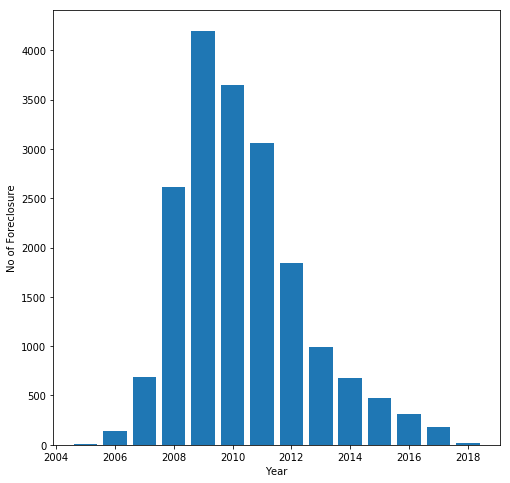

In [6]:
df_fore = df_all_fore['LPI_DT'].groupby([df_all_fore.LPI_DT.dt.year]).agg('count')
df_fore = pd.DataFrame(df_fore)

df_fore.columns = ['Foreclosures']

dd = df_fore.reset_index(level=0)
dd.columns = ['year','Foreclosures']

plt.figure(1, figsize=(8, 8))
plt.bar(dd['year'], dd['Foreclosures'], data=dd)
plt.xlabel('Year')
plt.ylabel('No of Foreclosure')
plt.show()

The plot above shows clearly that there was a spike in the number of foreclosures between 2008 and 2012. It can be noticed that the number of foreclosures was at the highest level between 2009 and 2010, but it reduced significantly from 2013, which could be as a result of full economic recovery. This suggests that the most risky period for loan foreclosures is from the first month of economic recession and 24 months thereafter. Hence this stusy will be looking at the profile of customers that are most likely to foreclose.

### What is the relationship between the the interest rate, loan to value, cummulative loan to value and foreclosures

We will explore the interest rate and loan to value (LTV) for all the loans in the sample below. LTV is the percentage of the loan to the value of asset. But we will also look at the cumulative loan to value (CLTV)

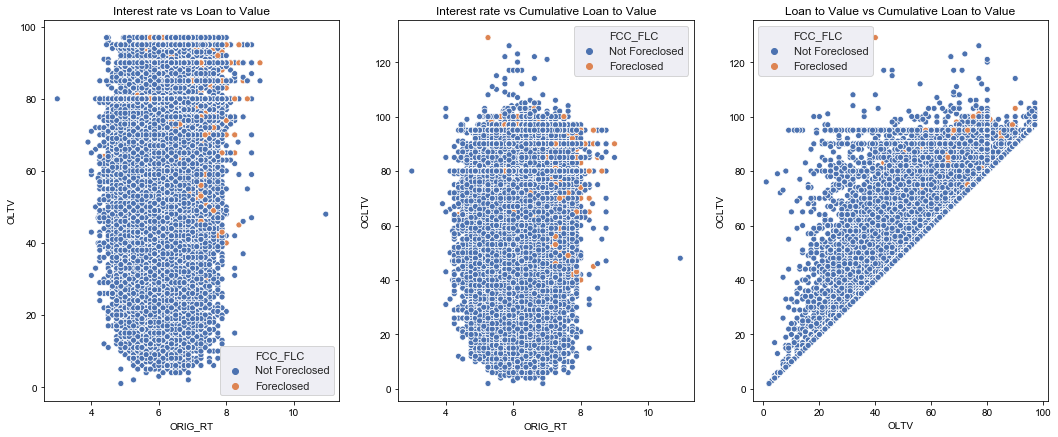

In [7]:
plt.rcParams["figure.figsize"] = (18,7)
fig, axs = plt.subplots(ncols=3)
sns.set(font_scale=1)


sns.scatterplot(x=df1.loc[:,'ORIG_RT'], y=df1.loc[:,'OLTV'], hue=df1['FCC_FLC'], ax = axs[0]).set_title('Interest rate vs Loan to Value')
sns.scatterplot(x=df1.loc[:,'ORIG_RT'], y=df1.loc[:,'OCLTV'], hue=df1['FCC_FLC'], ax = axs[1]).set_title('Interest rate vs Cumulative Loan to Value')
sns.scatterplot(x=df1.loc[:,'OLTV'], y=df1.loc[:,'OCLTV'], hue=df1['FCC_FLC'], ax = axs[2]).set_title('Loan to Value vs Cumulative Loan to Value')
plt.show()

The plot above compares the interest rate and loan to value of all the loans in the dataset. it appears that most of the foreclosed loans seem to be associated with higher interst rates and higher loan to value. However, the plot did not do enough justice to this fact because of the ratio of the foreclosed loans to those not foreclosed.

Hence the segment below will look at all loans that a foreclosed during the recession and 24 months there after the first recession month.

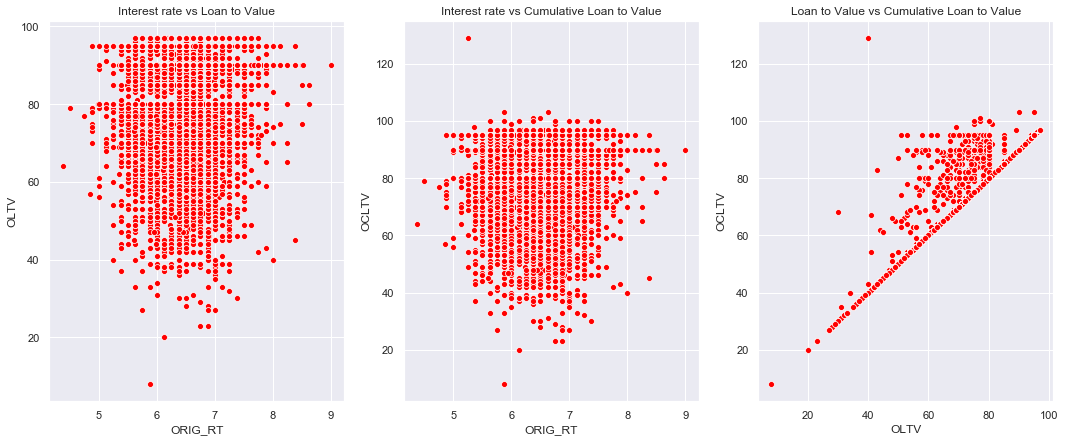

In [8]:

plt.rcParams["figure.figsize"] = (18,7)
fig, axs = plt.subplots(ncols=3)
sns.set(font_scale=1)


sns.scatterplot(x=df_fore_res.loc[:,'ORIG_RT'], y=df_fore_res.loc[:,'OLTV'], color='red', ax = axs[0]).set_title('Interest rate vs Loan to Value')
sns.scatterplot(x=df_fore_res.loc[:,'ORIG_RT'], y=df_fore_res.loc[:,'OCLTV'], color='red', ax = axs[1]).set_title('Interest rate vs Cumulative Loan to Value')
sns.scatterplot(x=df_fore_res.loc[:,'OLTV'], y=df_fore_res.loc[:,'OCLTV'], color='red', ax = axs[2]).set_title('Loan to Value vs Cumulative Loan to Value')
plt.show()

The first and the second plots show that many of the foreclosed loans have high interest rates between 6 and almost 9% in some cases. Also 3rd plor show  that some of the loans have high cummulative loan to value. Although tghis is expected in most cases.

### Is there a pattern in credit score of loans that default during recession?

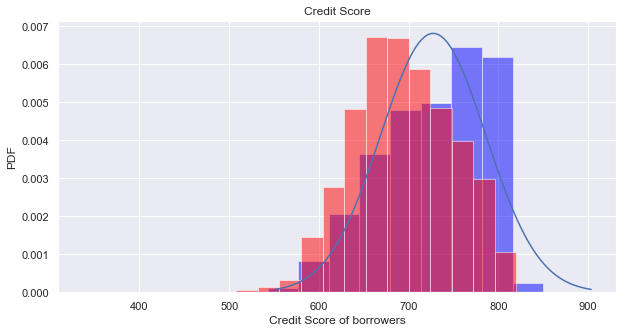

In [9]:
#Calculate mean and standard deviation of temperature
s_mean = df1['CSCORE_B'].mean()
s_std = df1['CSCORE_B'].std()


plt.rcParams["figure.figsize"] = (10,5)
_ = plt.hist(df1['CSCORE_B'], bins=15, density=True, alpha=0.5, color='blue')
_ = plt.hist(df_fore_res['CSCORE_B'], bins=15, density=True, alpha=0.5, color='red')


x = np.linspace(s_mean - 3*s_std, s_mean + 3*s_std, 100)
y = stats.norm.pdf(x, s_mean, s_std)
plt.plot(x,y)

_ = plt.xlabel('Credit Score of borrowers')
_ = plt.ylabel('PDF')
_ = plt.title('Credit Score')
plt.show()

#Calculate mean and standard deviation of temperature
s_mean = df1['CSCORE_MN'].mean()
s_std = df1['CSCORE_MN'].std()


plt.rcParams["figure.figsize"] = (10,5)
_ = plt.hist(df_fore_res['CSCORE_B'], bins=15, density=True, alpha=0.5, color='blue')
_ = plt.hist(df_fore_res['CSCORE_MN'], bins=15, density=True, alpha=0.5, color='red')


x = np.linspace(s_mean - 3*s_std, s_mean + 3*s_std, 100)
y = stats.norm.pdf(x, s_mean, s_std)
plt.plot(x,y)

_ = plt.xlabel('Credit Score of borrowers')
_ = plt.ylabel('PDF')
_ = plt.title('Credit Score')
plt.show()

The distribution credit score of loans foreclosed during recession peaks at about 680 with a majority range between 650 -720. However, the general distribution seem to be clustered around 760 - 820.

### Feature Engineering
Some of the variables extracted will cannot be used in its original form

From experiments carried out, dropping all the missing value seem to be more beneficial than trying to fill because it actually improved the percentage of Foreclosed loans of interest to those not foreclosed.

In [10]:
df2 = df1.drop(columns =['CSCORE_C', 'LPI_DTE', 'LPI_DT','MSA', 'ZIP_3','MI_PCT', 'LAST_STAT','OCLTV','ORIG_VAL'])
df_all = df2.dropna()
df_label = df_all.loc[:, ["FCC_FLG",'FCC_FLC']]

lbe = LabelEncoder()

df_features = df_all.drop(columns =["FCC_FLG",'FCC_FLC'])
df_features['ORIG_CHN'] = lbe.fit_transform(df_all['ORIG_CHN'])
df_features['FTHB_FLG'] = lbe.fit_transform(df_all['FTHB_FLG'])
df_features['PURPOSE'] = lbe.fit_transform(df_all['PURPOSE'])
df_features['PROP_TYP'] = lbe.fit_transform(df_all['PROP_TYP'])
df_features['OCC_STAT'] = lbe.fit_transform(df_all['OCC_STAT'])
df_features['STATE'] = lbe.fit_transform(df_all['STATE'])
df_features['RELOCATION_FLG'] = lbe.fit_transform(df_all['RELOCATION_FLG'])
df_features['MOD_FLAG'] = lbe.fit_transform(df_all['MOD_FLAG'])
df_features['Zero.Bal.Code'] = lbe.fit_transform(df_all['Zero.Bal.Code'])
#df_features['LAST_STAT'] = lbe.fit_transform(df_all['LAST_STAT'])

df_label['FCC_FLC'].value_counts()

Not Foreclosed    223808
Foreclosed         10075
Name: FCC_FLC, dtype: int64

There is a concerned that recoding the data may affect the result because of the many important categorical features. Hence dummy variables will be created for each of the categorical variables

In [11]:
df_feat = df_all.drop(columns =["FCC_FLG",'FCC_FLC'])
df_feature_d = pd.get_dummies(df_feat, columns=['ORIG_CHN', 'FTHB_FLG','PURPOSE','PROP_TYP',
                                           'OCC_STAT','RELOCATION_FLG','MOD_FLAG','STATE', 'Zero.Bal.Code'#'LAST_STAT'
                                           ], drop_first=True)
df_feature_d.shape

(233883, 82)

### Split Data into Training and Test Set and confirm proportions

In [12]:
scaler = StandardScaler()
transform = scaler.fit_transform(df_feature_d)

transform.shape

(233883, 82)

In [13]:
# Split the data into a training and test set.
X = df_feature_d
y = df_label['FCC_FLG']
xtrain, xtest, ytrain, ytest = train_test_split(X, y,random_state=5)


In [14]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(transform, df_label['FCC_FLG'].values,random_state=5)

In [15]:
#unique, counts = np.unique(ytrain[0], return_counts=True)
#dict(zip(unique, counts))
i = list(ytrain)
j = list(ytest)
print('There are {0} None ForeClosures and {1} Foreclosures in the training set'.format(i.count(0), i.count(1)))
print('There are {0} None ForeClosures and {1} Foreclosures in the training set'.format(j.count(0), j.count(1)))

There are 167876 None ForeClosures and 7536 Foreclosures in the training set
There are 55932 None ForeClosures and 2539 Foreclosures in the training set


This is a well proportioned split

### Baseline Model

In [51]:
clf = XGBClassifier(max_features=None)
# Fit the model on the trainng data.
clf.fit(xtrain1, ytrain1)
# Print the accuracy from the testing data.
print(accuracy_score(ytest1, clf.predict(xtest1)))

0.9786218809324281


### Cross Validation with Baseline Model

In [119]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 10
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [120]:
clf = XGBClassifier(max_features=None, )
score = cv_score(clf, xtrain1, ytrain1)
print(score)

0.9799044509048043


#### Feature Importance of CV model

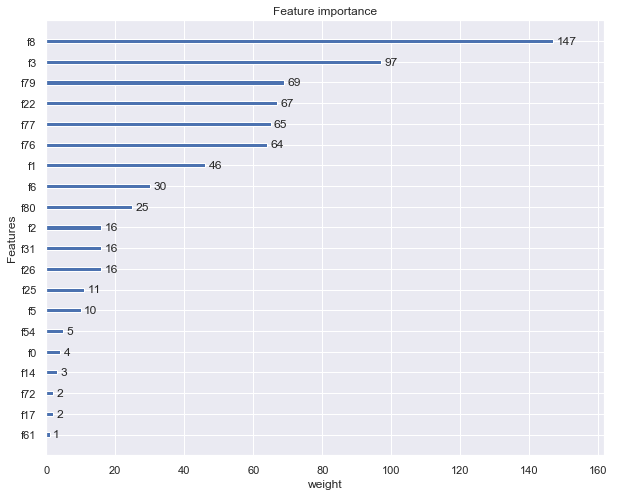

In [121]:
ax = plot_importance(clf, importance_type='weight', xlabel='weight', max_num_features=20)
ax.figure.set_size_inches(10,8)
pyplot.show()

In [122]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.get_booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v for k,v in imp_dict.items()}

dd = get_xgb_imp(clf, df_feature_d.columns)

In [114]:
#clf.get_booster().get_score(importance_type= 'weight')
#clf.get_booster().get_fscore()

In [163]:
dd1 = pd.DataFrame(
    {'features': list(dd.keys()),
     'coef': list(dd.values())
    })


In [162]:
feat = np.array(list(dd.values()))
lbl = np.array(list(dd.keys()))

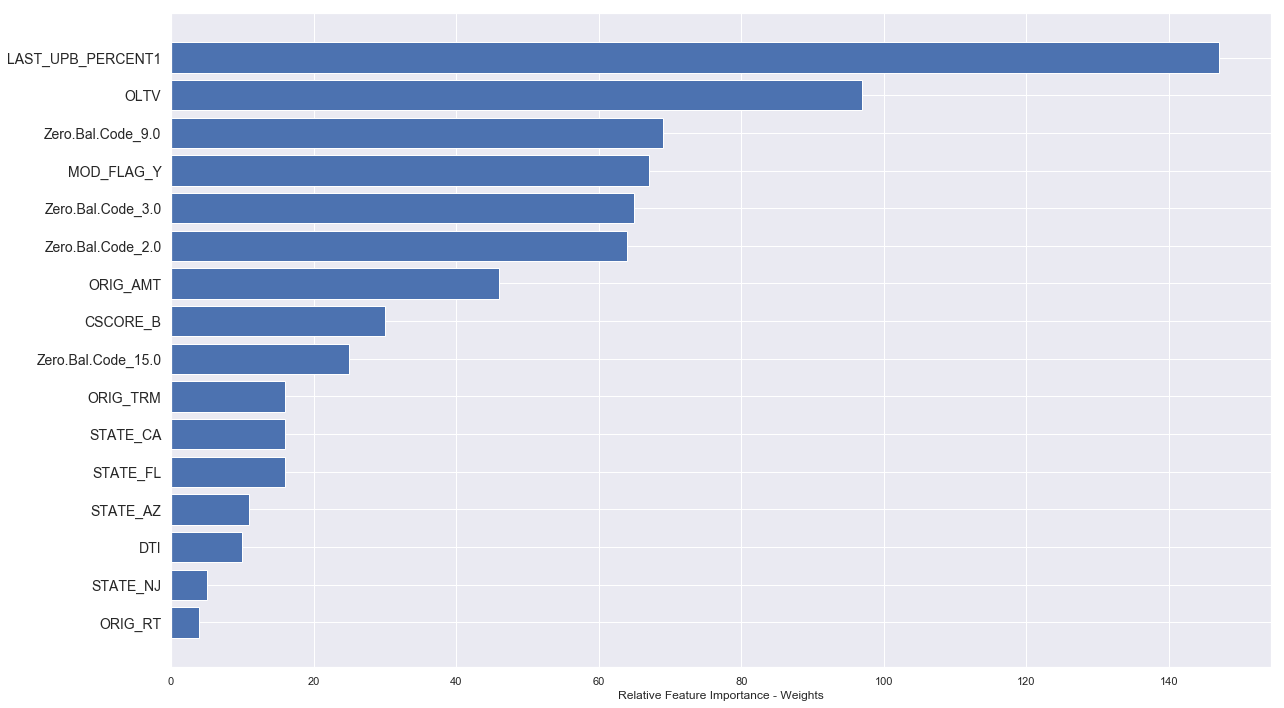

In [164]:
plt.rcParams["figure.figsize"] = (18,10)

feature_importance = feat
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos[-16:][::-1], feature_importance[sorted_idx][-16:][::-1], align='center')
featax.set_yticks(pos[-16:][::-1])
featax.set_yticklabels(np.array(lbl)[sorted_idx][-16:][::-1], fontsize=14)
featax.set_xlabel('Relative Feature Importance - Weights')

plt.tight_layout()   
plt.show()

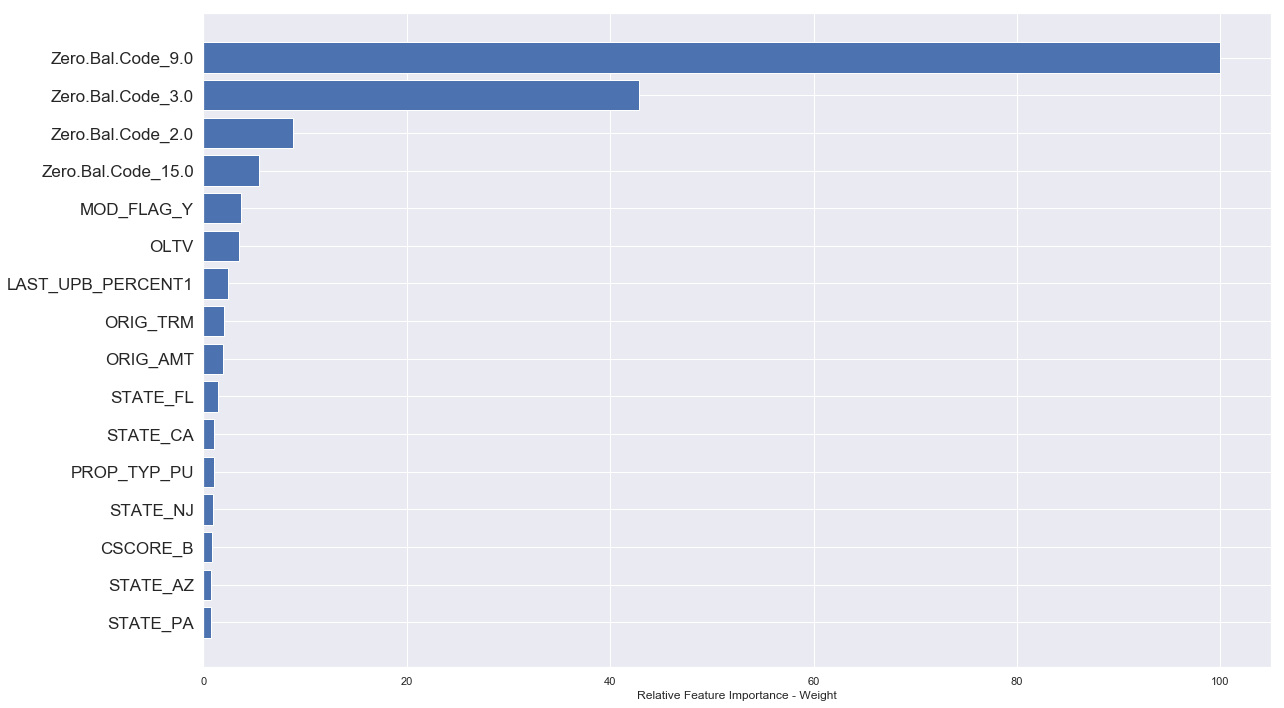

In [166]:
plt.rcParams["figure.figsize"] = (18,10)

feature_importance = abs(clf.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos[-16:][::-1], feature_importance[sorted_idx][-16:][::-1], align='center')
featax.set_yticks(pos[-16:][::-1])
featax.set_yticklabels(np.array(df_feature_d.columns)[sorted_idx][-16:][::-1], fontsize=17)
featax.set_xlabel('Relative Feature Importance - Gain')

plt.tight_layout()   
plt.show()

In [21]:
coef = (np.std(xtrain1, 0)*clf.feature_importances_)
coef_std = (np.std(df_feature_d.values, 0)*clf.feature_importances_)

In [64]:
feature_imp = pd.DataFrame(
    {'features': df_feature_d.columns,
     'coef': clf.feature_importances_,
     'coef_abs': abs(clf.feature_importances_)
    })

feature_imp.sort_values(by=['coef_abs'], ascending=False)
feature_imp.to_csv(path_or_buf='feat_imp_xgb_b.csv')

#### Confusion Matrix of Training set

In [23]:
tn, fp, fn, tp = confusion_matrix(clf.predict(xtrain1), ytrain1).ravel()
(tn, fp, fn, tp)

(165834, 1281, 2042, 6255)

#### Precision-Recall for training

In [24]:
print(classification_report(ytrain1, clf.predict(xtrain1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    167876
           1       0.75      0.83      0.79      7536

   micro avg       0.98      0.98      0.98    175412
   macro avg       0.87      0.91      0.89    175412
weighted avg       0.98      0.98      0.98    175412



#### ROC Curve Training

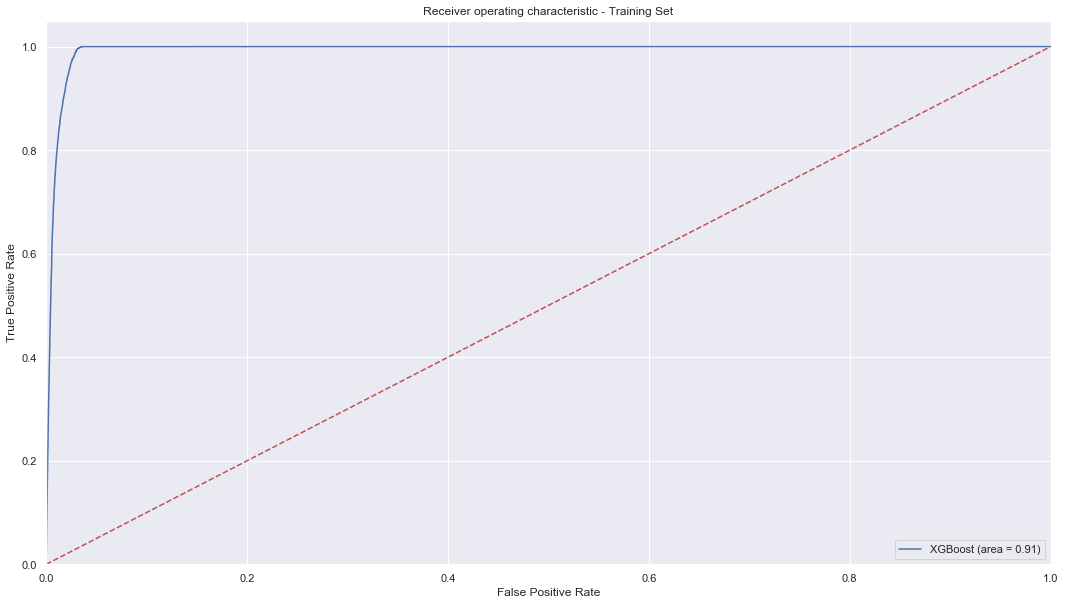

In [25]:
logit_roc_auc = roc_auc_score(ytrain1, clf.predict(xtrain1))
fpr, tpr, thresholds = roc_curve(ytrain1, clf.predict_proba(xtrain1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Training Set')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Confusion Matrix of Test set

In [26]:
tn, fp, fn, tp = confusion_matrix(clf.predict(xtest1), ytest1).ravel()
(tn, fp, fn, tp)

(55178, 478, 754, 2061)

#### Precision-Recall for test set

In [27]:
print(classification_report(ytest1, clf.predict(xtest1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     55932
           1       0.73      0.81      0.77      2539

   micro avg       0.98      0.98      0.98     58471
   macro avg       0.86      0.90      0.88     58471
weighted avg       0.98      0.98      0.98     58471



#### ROC Curve Test set

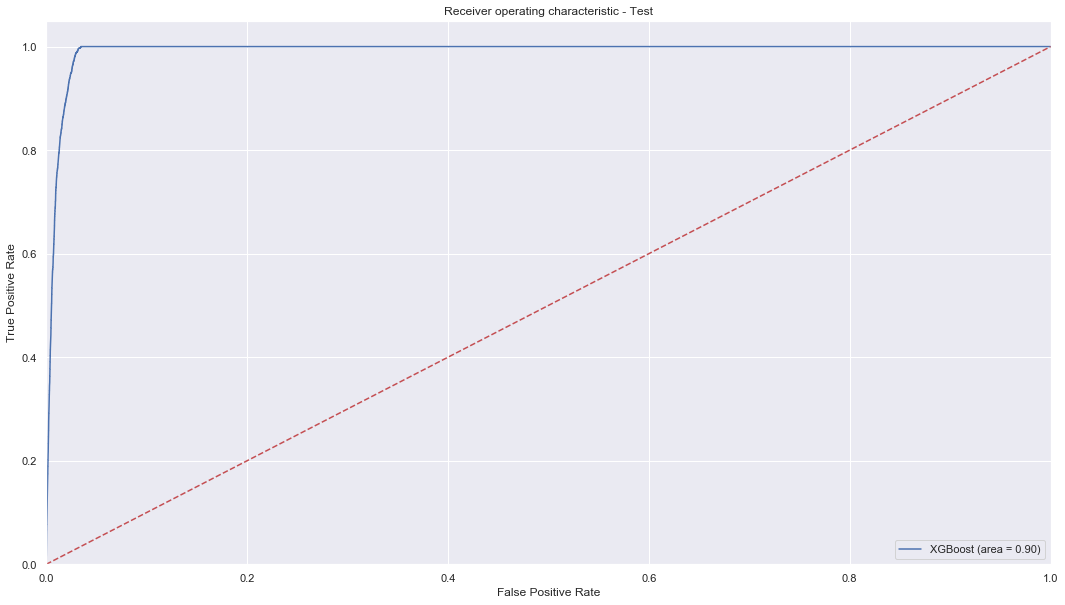

In [28]:

logit_roc_auc = roc_auc_score(ytest1, clf.predict(xtest1))
fpr, tpr, thresholds = roc_curve(ytest1, clf.predict_proba(xtest1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Test')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Importance of Features - Validation

In [29]:
feature_imp = pd.DataFrame(
    {'features': df_feature_d.columns,
     'coef': coef[0],
     'coef_abs': abs(coef[0])
    })

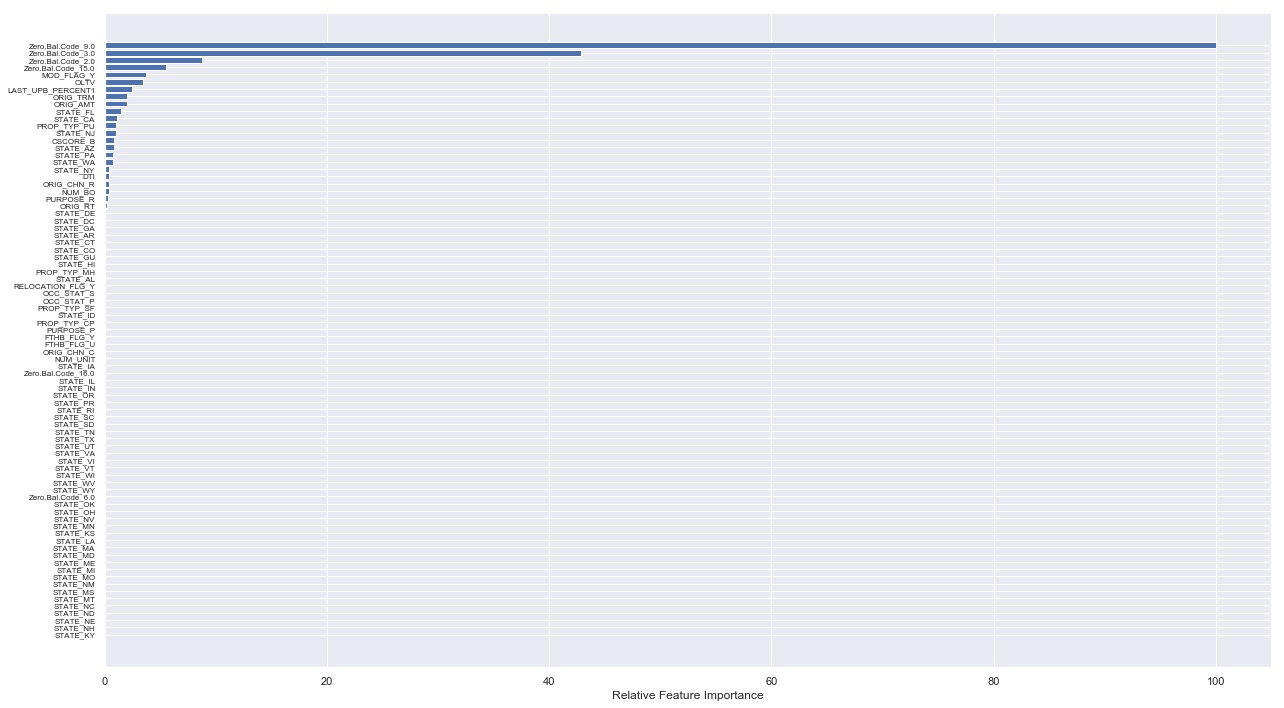

In [30]:
plt.rcParams["figure.figsize"] = (18,10)

#feature_importance = abs(clf.best_estimator_.coef_[0])
feature_importance = abs(clf.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(df_feature_d.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [31]:
logreg = XGBClassifier()
# Fit the model on the trainng data.
logreg.fit(xtrain, ytrain)
# Print the accuracy from the testing data.
print(accuracy_score(ytest, logreg.predict(xtest)))

0.9786218809324281


In [32]:
tn, fp, fn, tp = confusion_matrix(logreg.predict(xtest), ytest).ravel()
(tn, fp, fn, tp)

(55146, 464, 786, 2075)

In [33]:
ypred = logreg.predict(xtest)

In [34]:
len(ypred)

58471

In [35]:
result = pd.concat([xtest, ytest], axis=1)
result['FCC_PRED'] = ypred

In [36]:
#df_final = result.merge(df_yr, left_index=True, right_index=True)
df_final = result.join(df_yr)

In [37]:
len(df_final)

58471

In [38]:
pd.crosstab(df_final.VinYr, [df_final.FCC_FLG, df_final.FCC_PRED],margins=True)

FCC_FLG       0         1          All
FCC_PRED      0    1    0     1       
VinYr                                 
1999          2    0    0     0      2
2001          2    0    0     0      2
2002          9    0    0     0      9
2003         65    0    0     0     65
2004         66    0    0     0     66
2005       9191   75  140   221   9627
2006      22537  309  215   884  23945
2007      10591  234   69   616  11510
2008      12683  168   40   354  13245
All       55146  786  464  2075  58471

https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
https://scikit-learn.org/stable/modules/svm.html

https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

https://www.programcreek.com/python/example/99827/xgboost.plot_importance

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7